# Performance Measures
- https://homl.info/colab3

In [10]:
# 지난 시간 in a nutshell

import matplotlib
import matplotlib.pyplot
import pathlib
import sklearn.datasets
import sklearn.linear_model
import sklearn.model_selection

matplotlib.pyplot.rc('font', size=14)
matplotlib.pyplot.rc('axes', labelsize=14, titlesize=14)
matplotlib.pyplot.rc('legend', fontsize=14)
matplotlib.pyplot.rc('xtick', labelsize=10)
matplotlib.pyplot.rc('ytick', labelsize=10)

output_dir = pathlib.Path() / "images" / "end_to_end_project"
output_dir.mkdir(parents=True, exist_ok=True)
print(f'output_dir : {output_dir}')

def matplotlib_to_imagefile(output_dir, filename, imgext="png", tight_layout=True, resolution=300):
    path = output_dir / f"{filename}.{imgext}"
    if tight_layout:
        matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.savefig(path, format=imgext, dpi=resolution)

# 28 * 28 = 784
def plot_digit(vec_784):
    image = vec_784.reshape(28, 28)
    matplotlib.pyplot.imshow(image, cmap='binary')
    matplotlib.pyplot.axis('off')


dataset_save_dir = pathlib.Path("datasets")
mnist = sklearn.datasets.fetch_openml('mnist_784', data_home=dataset_save_dir, as_frame=False)
X, y = mnist.data, mnist.target
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.1, stratify = y)

y_train_3 = (y_train == '3') # 책과는 좀 다르게 3-classifier를 만들어 본다
y_test_3 = (y_test == '3')

sgd_clf = sklearn.linear_model.SGDClassifier()
sgd_clf.fit(X_train, y_train_3)

output_dir : images\end_to_end_project


c:\Users\ctint\anaconda3\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


SGDClassifier()

## Measuring Accuracy Using Cross-Validation

In [11]:
# 책은 왜 n_jobs 얘기를 안해주는 걸까...
# 책보다 cv를 좀 높여서 해본다
sklearn.model_selection.cross_val_score(sgd_clf, X_train, y_train_3, cv=5, scoring="accuracy", n_jobs=-1)

array([0.96587302, 0.96595238, 0.96007937, 0.95611111, 0.96277778])

In [12]:
# 이건 좀 더 step-by-step으로 하는거. 책에는 없고 colab 코드에서 발췌
# StratifiedKFold를 사용해서인지 위의 cross_val_score보다 좀 더 결과가 잘 나온다
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
# 여기에 의하면 stratification은 split에서 y(즉 아래의 y_train_3)에 대해 된다고 함

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=5)  # add shuffle=True if the dataset is not
                                       # already shuffled
for train_index, test_index in skfolds.split(X_train, y_train_3):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_3[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_3[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.952936507936508
0.9644444444444444
0.9715873015873016
0.9671428571428572
0.9565079365079365


In [13]:
# 위의 결과가 꽤 좋아보이지만 DummyClassifier와 비교해 보면 그렇게 좋은게 아니라는걸 알 수 있다
# DummyClassifier는 y에서 가장 흔한 class라고 무조건 리턴하며, 위의 경우 '3가 아닌것' 이 3보다 훨씬 많으므로
# 무조건 False라고 분류한다
# 그리고 그렇게만 해도 약 90% 정도의 accuracy를 보인다

from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_3)

sklearn.model_selection.cross_val_score(dummy_clf, X_train, y_train_3, cv=5, scoring="accuracy")


array([0.89801587, 0.89801587, 0.89801587, 0.89793651, 0.89793651])

In [16]:
# Skew된 데이터 (e.g. 90%가 False, 10%가 True) 에서는 accuracy가 좋은 성능 측정지표가 아니다
# 왜냐하면, 모델이 무조건 False라고 예측해도 90%의 확률로 정답을 맞출 수 있기 때문이다
# 그래서 이런 경우에는 Confusion Matrix를 사용한다

y_train_pred = sklearn.model_selection.cross_val_predict(sgd_clf, X_train, y_train_3, cv=5, n_jobs=-1)
print(len(y_train_pred))
print(y_train_pred) # cross_val_predict는 cross_val_score와 달리 각 fold의 예측값을 리턴한다

# 여기에서 y_train_pred가 1차원 array로 나오는 이유
# cv=3라고 한다면 1,(2,3) / 2,(1,3) / 3,(1,2) 이렇게 3개의 fold가 만들어지는 셈이고
# 그럼각각 (2,3)으로 train, 1로 test / (1,3)으로 train, 2로 test / (1,2)로 train, 3으로 test
# 이런식으로 한다음에 저 테스트 한 결과를 1,2,3 순서대로 합쳐서 1차원 array로 리턴하는 것이다
# 저걸 각각의 결과를 일일히 리턴하지 않고 정확도로 나타내면 cross_val_score가 되는 것이고
# 일일히 리턴하면 cross_val_predict가 된다

# 참고로 정말 저렇게 차례대로 나눈다기 보단 좀 더 잘 섞어서 나누긴 할거다
# 어쨌건 결과적으로 index 맞춰서 합쳐서 1차원 array로 리턴하는 것이다

63000
[False False False ... False False False]


In [19]:
# y_train_pred가 있고 y_train_3도 있으니 confusion matrix를 만들 수 있다
# row는 실제값, column은 예측값
# 즉 (0,0)은 실제 False, 예측 False, (0,1)은 실제 False, 예측 True, 
# (1,0)은 실제 True, 예측 False, (1,1)은 실제 True, 예측 True

cm = sklearn.metrics.confusion_matrix(y_train_3, y_train_pred)
print(cm)


[[55488  1085]
 [ 1502  4925]]


### Precision
- precision = TP/(TP+FP)
- 즉 precision이란 True로 분류 한 것 중에 진짜 True였던 것은 얼마나 많은가? 인 것
- 다르게 말하면 '내가 이것은 X요 하고 주장했을때 그 주장이 사실일 확률'. 나의 주장의 신뢰성

### Recall
- recall = TP/(TP+FN)
- 즉 recall이란 실제로 True였던 것 중에 몇개를 실제 True로 분류했는가?
- 다르게 말하면 '내가 X인 것을 X라고 분류해 낼 확률'. 내 분류 능력의 척도

### Precision과 Recall의 관계
- 예를 들어 Precision을 늘리려면 '내가 정말 X라고 자신 있는 것'만 X라고 하면 된다. 즉 X인지 아닌지 확실치 않은 것에 대해서는 X라고 하지 않으면 된다
- 이것은 달리 말해 X여부를 가르는 Threshold를 높이면 된다
- 근데 그렇게 되면 실제로 X인 것중 상당수가 X로 분류되지 않게 된다. 즉 recall이 낮아질 가능성이 높아진다
- recall을 늘리려면 '자신이 없어도 일단 X라고 분류' 하면 된다
- 이러면 실제로 X인 것 중에 많은 것이 X라고 분류될 것이다
- 근데 이것은 달리 말해 Threshold를 낮추는 것이기 때문에 X가 아닌 것도 X라고 분류될 가능성이 높아진다. 즉 precision이 낮아질 가능성이 높아진다
- 이와 같이 precision과 recall은 서로 반대될 수 있는 성질을 가지고 있다
    - 예를 들어 '안전 영상'을 음란물등으로 부터 분류해 내는 classifier를 만든다면 precision이 중요할 것이다. 즉 안전영상을 다소 놓치는 한이 있어도 음란물이 안전영상으로 분류되는건 막고 싶을 것이다
    - 귀중품등을 지키기 위해 CCTV에서 도둑을 분류하는 classifier는 recall을 높이고 싶을 것이다. 즉 무고한 사람을 의심하기도 하는 경우가 생길지라도 도둑을 반드시 놓치지 않는 classfier가 더 효과가 있을 것이다

In [27]:
cm = sklearn.metrics.confusion_matrix(y_train_3, y_train_pred)

print(cm)
TN = cm[0][0] # True Negative
FP = cm[0][1] # False Positive
FN = cm[1][0] # False Negative
TP = cm[1][1] # True Positive

precision = sklearn.metrics.precision_score(y_train_3, y_train_pred)
recall = sklearn.metrics.recall_score(y_train_3, y_train_pred)

print(f'precision: {precision}, recall: {recall}')
print(f'{TP}/({TP}+{FP}): {TP/(TP+FP)}, {TP}/({TP}+{FN}): {TP/(TP+FN)}')

[[55488  1085]
 [ 1502  4925]]
precision: 0.8194675540765392, recall: 0.7662984285047456
4925/(4925+1085): 0.8194675540765392, 4925/(4925+1502): 0.7662984285047456


### F-score
- F-score는 precision과 recall의 harmonic mean(조화 평균)이다
- https://en.wikipedia.org/wiki/Harmonic_mean
- 책의 설명에 따르면 precision과 recall이 둘 다 높아야 harmonic mean이 높아지기 때문에 단 하나의 수치로 classifier를 평가하기 적합하다고 한다
- 실제로 분수는 분모가 0에 가까워 질수록 무한에 가깝게 기울기가 치솟으므로 precision과 recall둘 중 하나가 너무 낮으면 (즉 과도한 trade-off를 하면) 수치가 급격히 안좋아지기 때문에 이것을 하나의 수치로 편리하게 알기 좋다고 할 수 있을 것 같다

- predict를 대신해서 decision_function을 이용하면 classifier가 각 instance에 어떤 점수를 줬는지 알 수 있다
- 이걸 이용하면 자신이 자체적으로 threshold를 조정해서 precision-recall tradeoff를 해볼 수 있다
- scikit-learn에서 threshold를 직접 조작하게 만드는 법은 제공하지 않는다고 함

In [28]:
y_scores = sgd_clf.decision_function(X_train)


[-4730.9182561  -2946.26277459 -7296.58491638 ... -1176.82735221
 -1698.73645313 -4387.87662571]


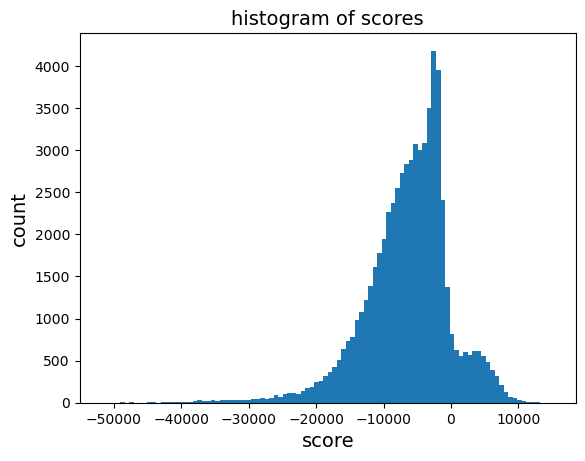

In [29]:
# 위의 결과를 histogram으로 나타내보면 다음과 같다

def plot_histogram(float_array, bins=10, xlabel='value', ylabel='count', title='histogram'):
    matplotlib.pyplot.figure()
    matplotlib.pyplot.hist(float_array, bins=bins)
    matplotlib.pyplot.xlabel(xlabel)
    matplotlib.pyplot.ylabel(ylabel)
    matplotlib.pyplot.title(title)
    matplotlib.pyplot.show()

plot_histogram(y_scores, bins=100, xlabel='score', ylabel='count', title='histogram of scores')

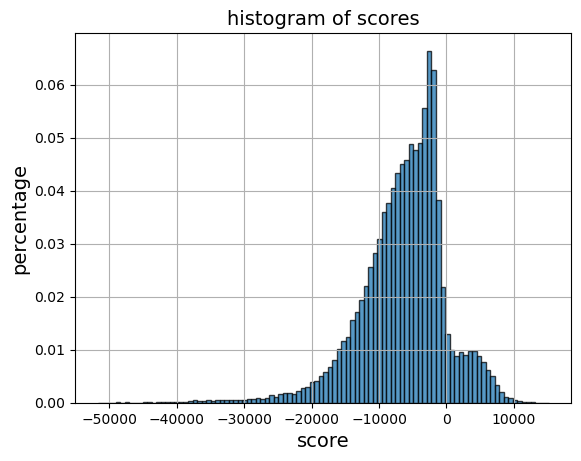

In [61]:
# 이건 percentage로 나타낸 histogram이다

import numpy

def plot_percentage_histogram(float_array, bins=10, xlabel='Values', ylabel='Percentage', title='Histogram', cumulative=False):
    # 데이터 포인트의 가중치를 계산합니다. 각 데이터 포인트의 가중치는 1 / (전체 데이터 포인트 수) 입니다.
    weights = numpy.ones_like(float_array) / float_array.size
    fig, ax = matplotlib.pyplot.subplots()
    
    # 가중치를 적용하여 히스토그램을 그립니다. 이를 통해 빈도 대신 백분율이 표시됩니다.
    # n = 각 bin의 데이터 포인트 수
    # bin_edges = 각 bin의 경계값
    # patches = 각 bin을 표현하는 matplotlib.patches.Rectangle 객체
    n, bin_edges, patches = ax.hist(float_array, bins=bins, weights=weights, edgecolor='k', alpha=0.75, cumulative=cumulative)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True)
    return fig, ax

fig, ax = plot_percentage_histogram(y_scores, bins=100, xlabel='score', ylabel='percentage', title='histogram of scores')

matplotlib.pyplot.show()

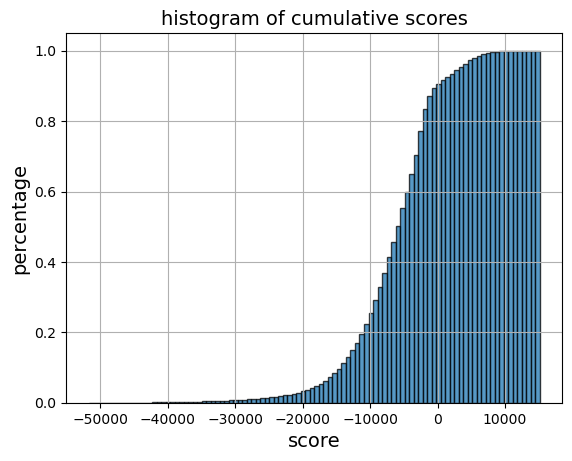

In [62]:
fig, ax = plot_percentage_histogram(y_scores, bins=100, xlabel='score', ylabel='percentage', title='histogram of cumulative scores', cumulative=True)

matplotlib.pyplot.show()

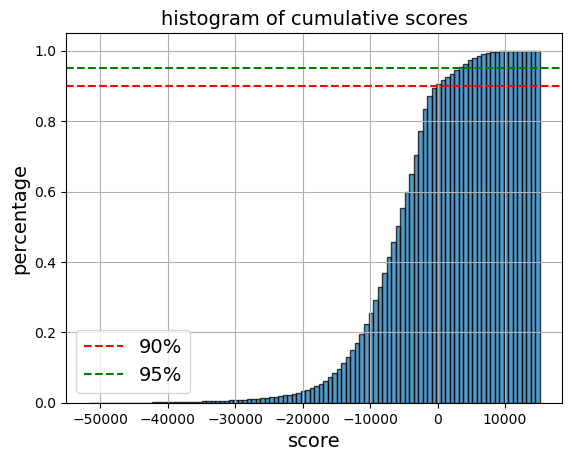

In [64]:
fig, ax = plot_percentage_histogram(y_scores, bins=100, xlabel='score', ylabel='percentage', title='histogram of cumulative scores', cumulative=True)

def add_horizontal_line(fig, ax, y_value, color='r', linestyle='--', label=None):
    ax.axhline(y=y_value, color=color, linestyle=linestyle, label=label)
    if label:
        ax.legend()
    return fig, ax

fig, ax = add_horizontal_line(fig, ax, 0.9,  color='r', linestyle='--', label='90%')
fig, ax = add_horizontal_line(fig, ax, 0.95, color='g', linestyle='--', label='95%')

matplotlib.pyplot.show()

In [67]:
threshold = 0
y_train_pred_90 = (y_scores > threshold)

def true_false_ratio(boolean_array):
    true_count = numpy.count_nonzero(boolean_array)
    false_count = len(boolean_array) - true_count
    total_count = len(boolean_array)

    true_ratio = true_count / total_count
    false_ratio = false_count / total_count

    return true_ratio, false_ratio

true_ratio, false_ratio = true_false_ratio(y_train_pred_90)
print(f'true ratio: {true_ratio}, false ratio: {false_ratio}')


true ratio: 0.10196825396825397, false ratio: 0.8980317460317461


In [82]:
# cross_val_predict를 이용하면 precision과 recall의 trade-off를 확인할 수 있다

y_scores = sklearn.model_selection.cross_val_predict(sgd_clf, X_train, y_train_3, cv=5, method='decision_function', n_jobs=-1)
precisions, recalls, thresholds = sklearn.metrics.precision_recall_curve(y_train_3, y_scores)
threshold_idx = (thresholds >= threshold).argmax()  # first index ≥ threshold


56990 1.8155248935440795


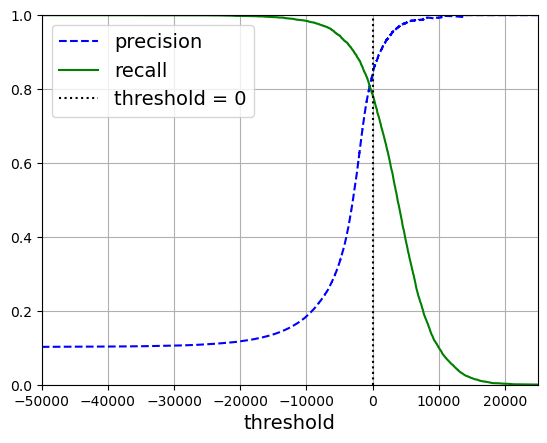

In [86]:
print(threshold_idx, thresholds[threshold_idx])

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    matplotlib.pyplot.figure()
    matplotlib.pyplot.xlim(-50000, 25000)
    matplotlib.pyplot.ylim(0.0 ,1.0)
    matplotlib.pyplot.plot(thresholds, precisions[:-1], 'b--', label='precision')
    matplotlib.pyplot.plot(thresholds, recalls[:-1], 'g-', label='recall')
    matplotlib.pyplot.xlabel('threshold')
    matplotlib.pyplot.vlines(thresholds[threshold_idx], 0, 1.0, 'k', 'dotted', label='threshold = 0')
    # matplotlib.pyplot.vlines(3000, 0, 1.0, 'k', 'dotted', label='threshold = 3000')
    matplotlib.pyplot.legend()
    matplotlib.pyplot.grid()
    matplotlib.pyplot.show()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

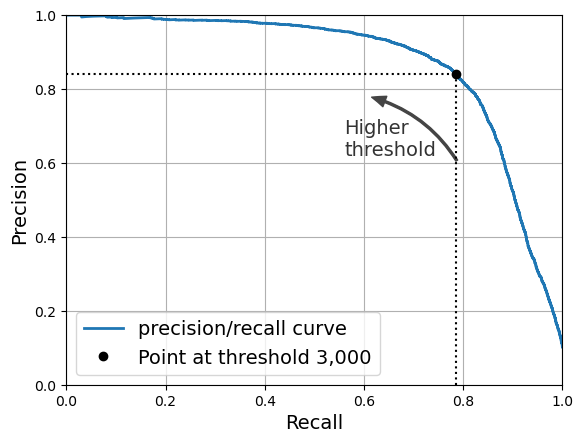

In [87]:
# recall과 precision을 그래프로 나타내보면 다음과 같다
matplotlib.pyplot.plot(recalls, precisions, linewidth=2, label='precision/recall curve')
matplotlib.pyplot.plot([recalls[threshold_idx], recalls[threshold_idx]], [0., precisions[threshold_idx]], "k:")
matplotlib.pyplot.plot([0.0, recalls[threshold_idx]], [precisions[threshold_idx], precisions[threshold_idx]], "k:")
matplotlib.pyplot.plot([recalls[threshold_idx]], [precisions[threshold_idx]], "ko",
         label="Point at threshold 3,000")
matplotlib.pyplot.gca().add_patch(matplotlib.patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
matplotlib.pyplot.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
matplotlib.pyplot.xlabel("Recall")
matplotlib.pyplot.ylabel("Precision")
matplotlib.pyplot.axis([0, 1, 0, 1])
matplotlib.pyplot.grid()
matplotlib.pyplot.legend(loc="lower left")
matplotlib.pyplot.show()

In [88]:
idx_for_90_precision = numpy.argmax(precisions >= 0.90)
threshold_for_90_precision = thresholds[idx_for_90_precision]
print(f'threshold for 90% precision: {threshold_for_90_precision}')

threshold for 90% precision: 1145.3412085611785


In [89]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)
print(sklearn.metrics.precision_score(y_train_3, y_train_pred_90))
recall_at_90_precision = sklearn.metrics.recall_score(y_train_3, y_train_pred_90)
print(recall_at_90_precision)


0.9001182033096927
0.7109071106270421


In [92]:
# SGDClassifier 말고 RandomForestClassifier를 사용해보자
import sklearn.ensemble

forest_clf = sklearn.ensemble.RandomForestClassifier()
y_probas_forest = sklearn.model_selection.cross_val_predict(forest_clf, X_train, y_train_3, cv=5, n_jobs=-1, method="predict_proba")
print(y_probas_forest[:2])

[[1.   0.  ]
 [0.89 0.11]]


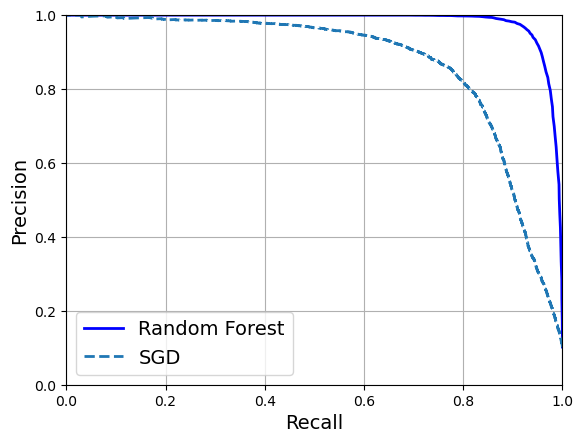

In [93]:
# The second column contains the estimated probabilities for the positive class, so let’s
# pass them to the precision_recall_curve() function:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = sklearn.metrics.precision_recall_curve(y_train_3, y_scores_forest)

matplotlib.pyplot.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
matplotlib.pyplot.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# extra code – just beautifies and saves Figure 3–8
matplotlib.pyplot.xlabel("Recall")
matplotlib.pyplot.ylabel("Precision")
matplotlib.pyplot.axis([0, 1, 0, 1])
matplotlib.pyplot.grid()
matplotlib.pyplot.legend(loc="lower left")

matplotlib.pyplot.show()

In [94]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive proba ≥ 50%
f1_forest = sklearn.metrics.f1_score(y_train_3, y_train_pred_forest)
print(f'f1 score for random forest: {f1_forest}')

f1 score for random forest: 0.9173650687227622
